# Trading Stocks Without Batching

In this notebook, we will see how a pretrained environment and agent performs on a trading dataset. We will analyze various algorithms and evaulate the same. This is just to set an example of how to use RL agents and environment as well as to draw a comparative picture of how batching is implemented and is important for the models.

In [28]:
pip install tensorflow stable-baselines3 gym-anytrading gym

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 1. Bring in Yfinance  Data 

In [4]:
pip install yfinance 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import yfinance as yf

symbol = 'BTC-USD'
start_date = '1900-01-01'
end_date = '2023-08-01'

stock_data = yf.download(symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [6]:
stock_data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Basic information on the stock data

In [30]:
df=pd.DataFrame(data=stock_data,columns=['Open','High','Low','Close','Volume'])

In [31]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [32]:
df.shape[0]

3240

In [33]:
import gymnasium as gym
import gym_anytrading

# Building the environment and using an already built environment

In [34]:
env = gym.make(
    'stocks-v0',
    df=df,
    window_size=10,
    frame_bound=(10, 300),
)

In [12]:
env.signal_features[:5] # signal features of the environment. this reperesents the extracted features over time.

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.signal_features to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.signal_features` for environment variables or `env.get_wrapper_attr('signal_features')` that will search the reminding wrappers.
  logger.warn(


array([[457.334   ,   0.      ],
       [424.44    , -32.894012],
       [394.796   , -29.644012],
       [408.904   ,  14.108002],
       [398.821   , -10.082977]], dtype=float32)

# Basic Environment Information

In [13]:
env.action_space # sell and buy, agent can take either of these actions. Containing discrete values of 0=Sell and 1=Buy.

Discrete(2)

In [14]:
print("Environment information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

Environment information:
> shape: (10, 2)
> df.shape: (3240, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 28.38360344510513


info {'total_reward': 36.68096923828125, 'total_profit': 0.44381902504872445, 'position': <Positions.Long: 1>}


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_wrapper_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


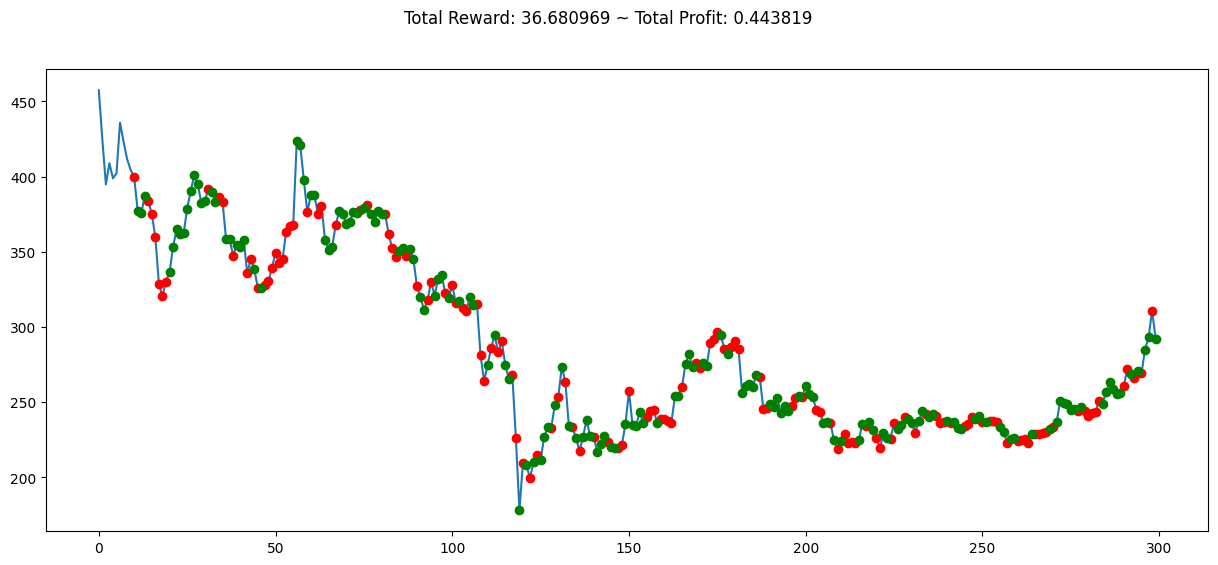

In [35]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)[1:]
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla() 
env.render_all()
plt.show()

Red markers indicate the stock being shorted and green markers indicate the stock being longed.
Shorting stock: Profiting from a stock's decline by selling borrowed shares, aiming to buy them back at a lower price.
Longing stock: Profiting from a stock's rise by buying and holding shares, with the expectation of selling them at a higher price.

Above graph shows the agent taking RANDOM actions. The total profit is the percentage of the overall profit. 0.44 represents there has been a loss of the stock. Profit value would be represented as a percentage greater than 1.

# Building the Environment and Training the model

In [36]:
env = gym.make(
    'stocks-v0',
    df=df,
    window_size=10,
    frame_bound=(10,3000),
)

In [49]:
# how training happens
from stable_baselines3 import A2C

model =  A2C("MlpPolicy", env)
model.learn(total_timesteps=1)
print("Learning finished...")
print(model)                    

Learning finished...


In [50]:
def showProgress():
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()

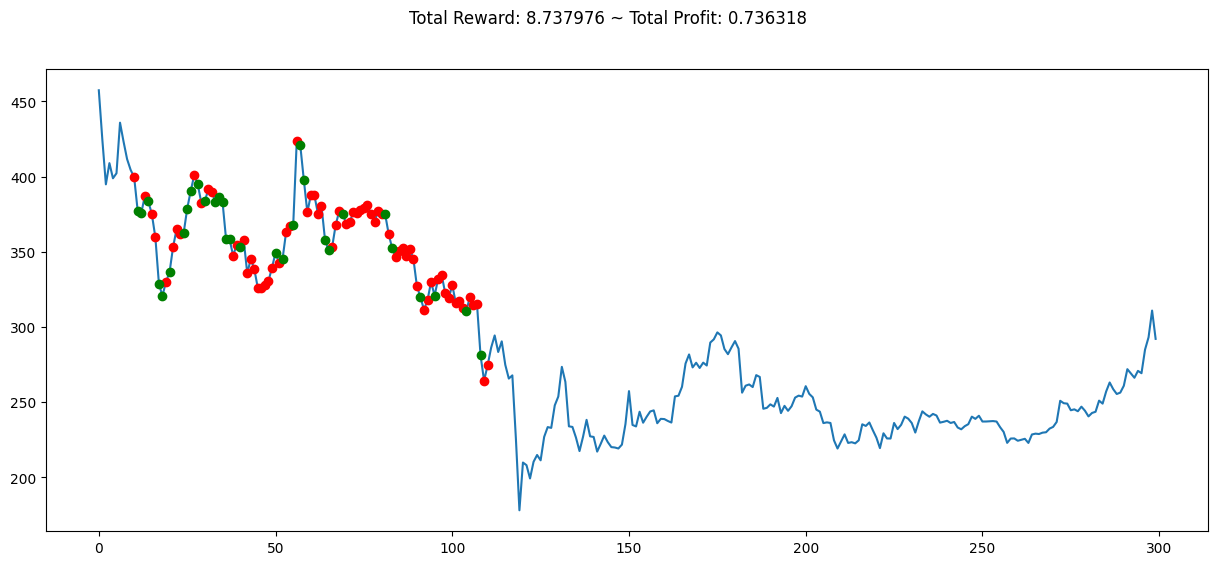

Learning finished...


In [52]:
from stable_baselines3 import A2C

model =  A2C("MlpPolicy", env)
model.learn(total_timesteps=100)
showProgress()
print("Learning finished...")

# 4. Evaluation

Average Return: 3.6837841796875


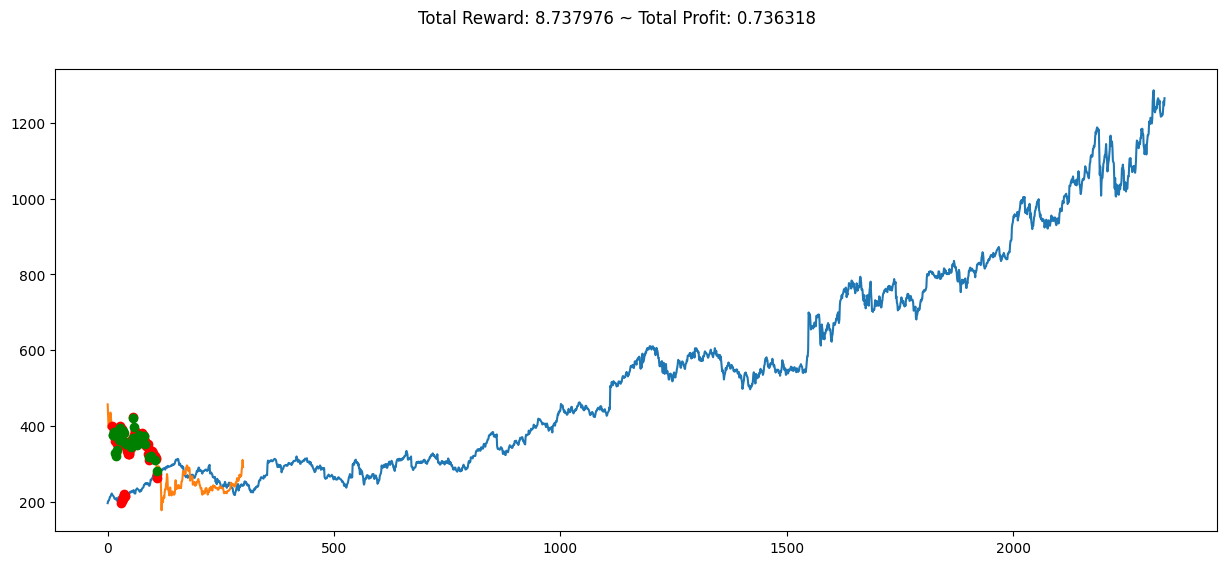

In [53]:
import numpy as np

eval_env =gym.make(
    'stocks-v0',)

num_episodes = 100  # Number of evaluation episodes
total_rewards = []  # Store total rewards for each episode

for episodes in range(num_episodes):
    state = eval_env.reset()
    episode_reward = 0
    num_batches = 3
    batches = np.array_split(state[0], num_batches)
    for i, batch in enumerate(batches):
            action, _ = model.predict(batch)
            next_state= eval_env.step(action)[0]
            reward=eval_env.step(action)[4]['total_reward']
            done=eval_env.step(action)[2]
            episode_reward += reward
            state = next_state
            if done:
                flag=False
                break
    total_rewards.append(episode_reward)

average_return = np.mean(total_rewards)

print(f"Average Return: {average_return}")

plt.figure(figsize=(15,6))
plt.cla()
eval_env.render_all()
env.render_all()
plt.show()

In [42]:
import numpy as np
env = gym.make(
    'stocks-v0',
    df=df,
    window_size=10,
    frame_bound=(10,300),
)
from stable_baselines3 import DQN

dqnmodel =  DQN("MlpPolicy", env)
dqnmodel.learn(total_timesteps=1000)
print("Learning finished...")
print(dqnmodel)                    

Learning finished...


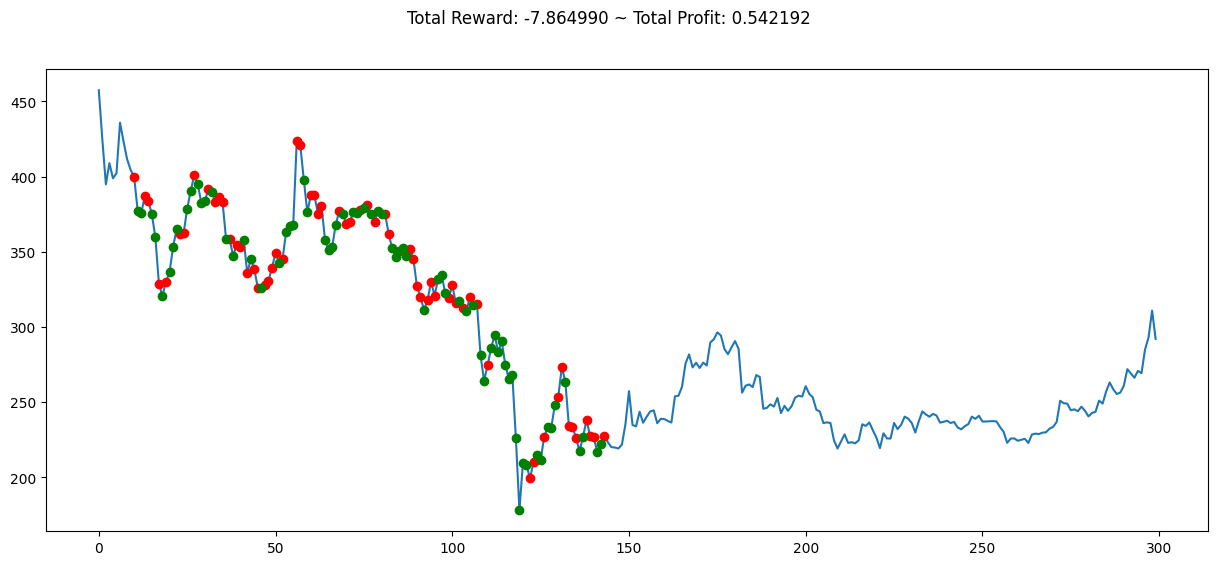

In [43]:
import numpy as np
env = gym.make(
    'stocks-v0',
    df=df,
    window_size=10,
    frame_bound=(10,300),
)
from stable_baselines3 import DQN

dqnmodel =  A2C("MlpPolicy", env)
dqnmodel.learn(total_timesteps=1000)
showProgress()

# Evaluation of DQN Algorithm Model

Average Return: -4.606447998046875


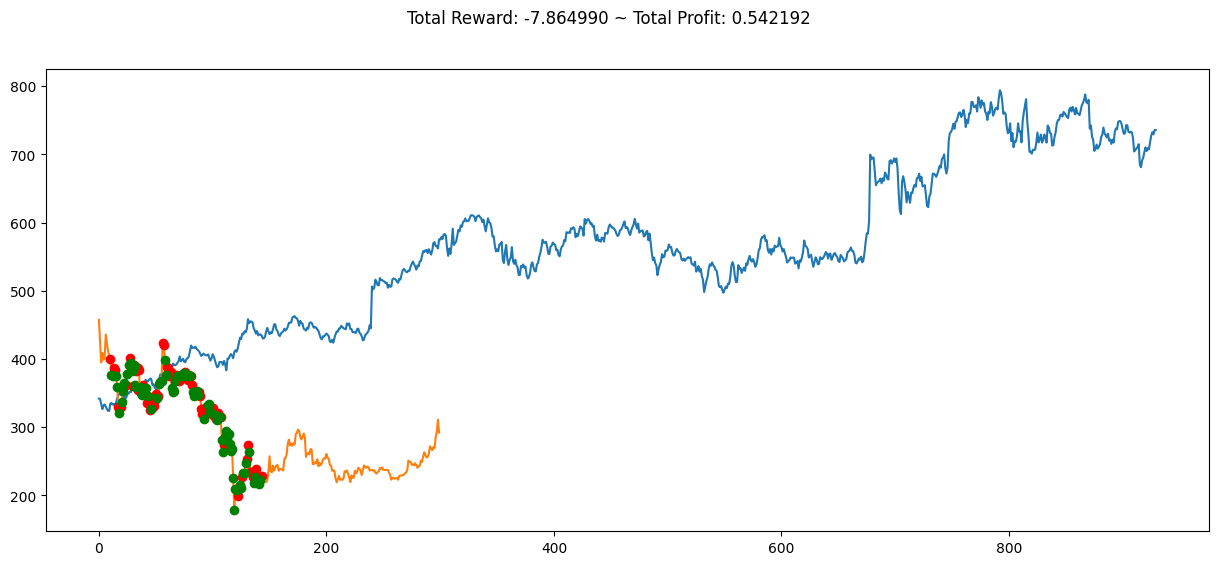

In [44]:
import numpy as np

eval_env =gym.make(
    'stocks-v0',frame_bound=(900,1800))

num_episodes = 3000  # Number of evaluation episodes
total_rewards = []  # Store total rewards for each episode

for episodes in range(num_episodes):
    state = eval_env.reset()
    episode_reward = 0
    num_batches = 3
    batches = np.array_split(state[0], num_batches)
    for i, batch in enumerate(batches):
            action, _ = dqnmodel.predict(batch)
            next_state= eval_env.step(action)[0]
            reward=eval_env.step(action)[4]['total_reward']
            done=eval_env.step(action)[2]
            episode_reward += reward
            state = next_state
            if done:
                flag=False
                break
    total_rewards.append(episode_reward)

average_return = np.mean(total_rewards)

print(f"Average Return: {average_return}")

plt.figure(figsize=(15,6))
plt.cla()
eval_env.render_all()
env.render_all()
plt.show()

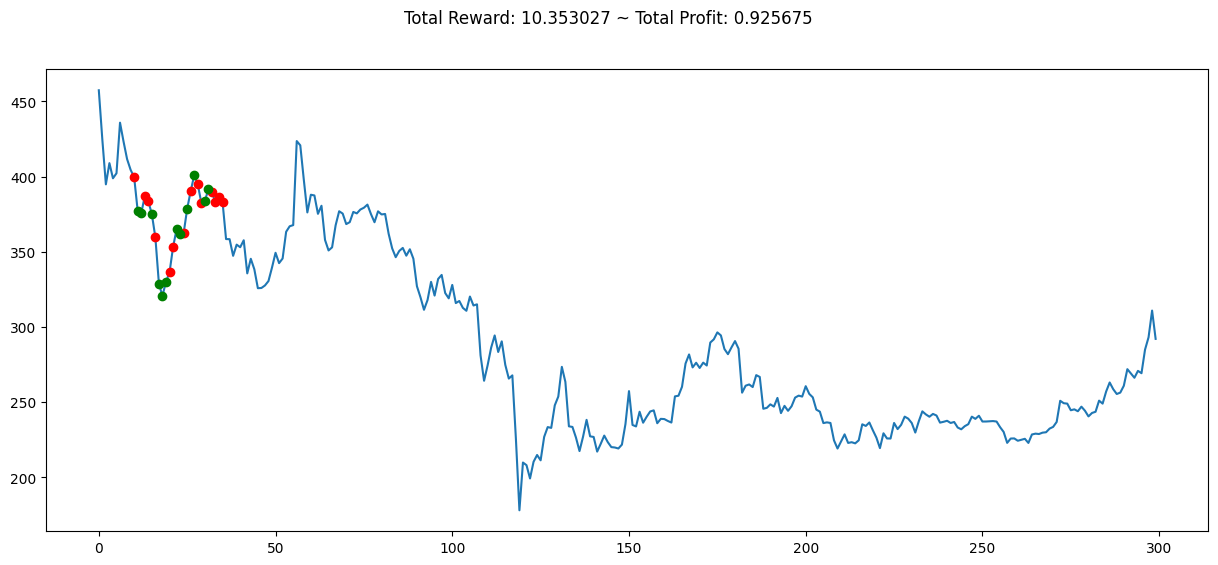

In [45]:
import numpy as np
env = gym.make(
    'stocks-v0',
    df=df,
    window_size=10,
    frame_bound=(10,300),
)
from stable_baselines3 import PPO

ppoModel =  PPO("MlpPolicy", env)
ppoModel.learn(total_timesteps=1000)
showProgress()

# Evaluation of PPO Algorithm Model

Average Return: -4.384172607421875


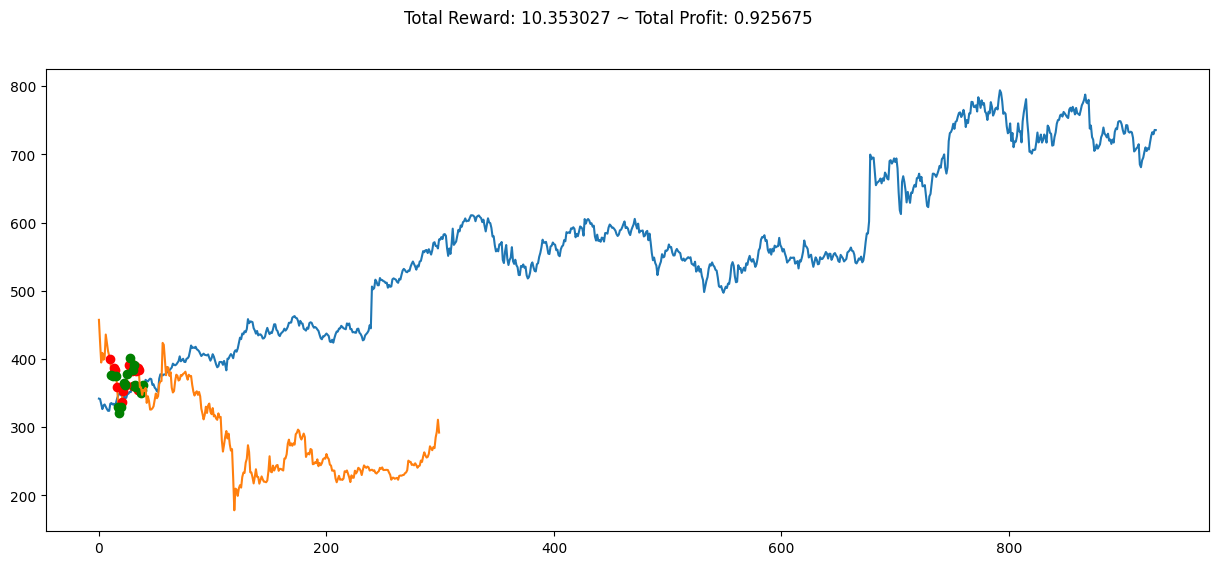

In [46]:
import numpy as np

eval_env =gym.make(
    'stocks-v0',frame_bound=(900,1800))

num_episodes = 3000  # Number of evaluation episodes
total_rewards = []  # Store total rewards for each episode

for episodes in range(num_episodes):
    state = eval_env.reset()
    episode_reward = 0
    num_batches = 3
    batches = np.array_split(state[0], num_batches)
    for i, batch in enumerate(batches):
            action, _ = ppoModel.predict(batch)
            next_state= eval_env.step(action)[0]
            reward=eval_env.step(action)[4]['total_reward']
            done=eval_env.step(action)[2]
            episode_reward += reward
            state = next_state
            if done:
                flag=False
                break
    total_rewards.append(episode_reward)

average_return = np.mean(total_rewards)

print(f"Average Return: {average_return}")

plt.figure(figsize=(15,6))
plt.cla()
eval_env.render_all()
env.render_all()
plt.show()

# Results 
Here we can see that the model is able to trade but still is not able to perform as per expected and not gain much profit. 
The PPO Algorithm performs the best, followed by A2C and then at last comes DQN.

# Next Notebook
In the next notebook, we will look at the results of the batching procedure and see if it is able to outperform the built in stock trading agent.